# Exoplanet Candidate Modeling

This notebook summarizes the performance of the logistic regression and XGBoost models trained by the pipeline, and demonstrates how to load the saved model to score new candidates.


In [1]:
import json
import pathlib
import matplotlib.pyplot as plt
from PIL import Image  # if you want to display saved plots
import pandas as pd
import joblib
import yaml


Only the top-level keys are shown here. Each entry contains cross-validation and holdout metrics saved by the training pipeline.

In [2]:
metrics_path = pathlib.Path("../artifacts/metrics.json")
with metrics_path.open() as f:
    metrics = json.load(f)

metrics.keys()


dict_keys(['logistic', 'xgboost'])

##  Model comparison
Logistic regression vs XGBoost on ROC-AUC and F1, using cross-validation and a holdout set.

In [3]:
rows = []
for model_name, vals in metrics.items():
    cv = vals["cv"]["mean"]
    holdout = vals["holdout"]
    rows.append({
        "model": model_name,
        "ROC-AUC (CV)": cv["roc_auc"],
        "F1 (CV)": cv["f1"],
        "ROC-AUC (holdout)": holdout["roc_auc"],
        "F1 (holdout)": holdout["f1"],
    })

summary = pd.DataFrame(rows)
summary.round(3)
summary

,model,ROC-AUC (CV),F1 (CV),ROC-AUC (holdout),F1 (holdout)
0,logistic,0.890833,0.851262,0.884405,0.846349
1,xgboost,0.989804,0.950985,0.988989,0.954343


## Calibration and precision–recall

Calibration curves show how well predicted probabilities match observed confirmation rates. Precision–recall curves highlight performance on the positive (confirmed) class.


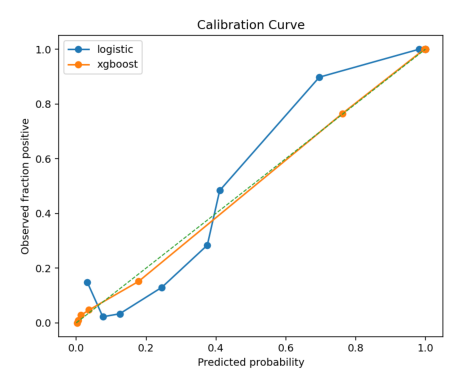

In [4]:
img = Image.open("../artifacts/plots/calibration.png")
plt.imshow(img)
plt.axis("off")
plt.show()

XGBoost stays closer to the diagonal line than logistic regression, indicating better-calibrated probabilities on the holdout set.


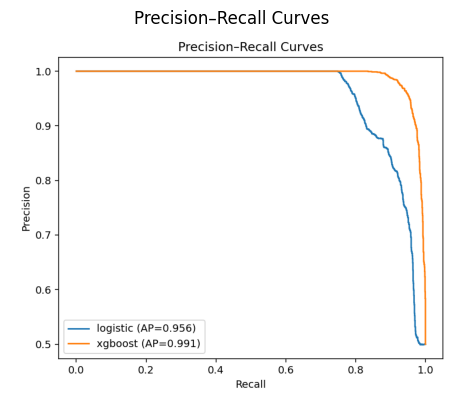

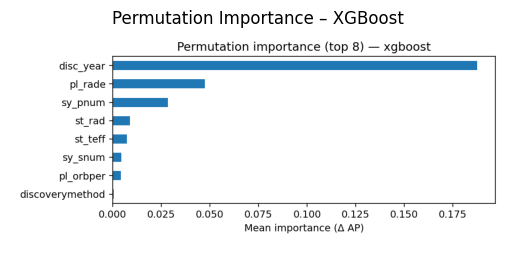

In [5]:


for fname, title in [
    ("pr_curves.png", "Precision–Recall Curves"),
    ("perm_importance_xgboost.png", "Permutation Importance – XGBoost"),
]:
    img = Image.open(f"../artifacts/plots/{fname}")
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


XGBoost achieves higher precision at almost all recall levels, which is useful when prioritizing likely confirmations from many candidates.


## Feature importance

Permutation importance for the XGBoost model highlights which physical and observational parameters contribute most to the predictions.


## Example: scoring a candidate

Below, we reload the trained XGBoost model, select a single candidate from the sample table, and compute the probability that it is a confirmed exoplanet.


In [6]:
# Load feature list from config
with open("../configs/train.yaml", "r") as f:
    cfg = yaml.safe_load(f)

feature_cols = cfg["features"]["include"]

# Load trained model
model_path = "../artifacts/models/model_xgboost.joblib"
model = joblib.load(model_path)

# Use a sample row
df = pd.read_csv("../data/raw/pscomppars_sample.csv")
X_sample = df[feature_cols].iloc[[0]]

proba = model.predict_proba(X_sample)[0, 1]
proba
candidate = df[feature_cols].iloc[[0]]
display(df.iloc[[0]][["pl_name"] + feature_cols].T.head(10))
print("Predicted confirmation probability:", round(proba, 3))


,0
pl_name,3204.01
pl_orbper,4.044654
pl_rade,2.44
st_teff,5172.7
st_rad,0.95
sy_snum,1.0
sy_pnum,1.0
disc_year,2016.0
discoverymethod,Transit


Predicted confirmation probability: 0.069
